In [1]:
import numpy as np
import gc
import matplotlib.pyplot as plt
from sklearn_sfa_master.sksfa import HSFA
from sklearn.preprocessing import StandardScaler

In [2]:
data = np.load('data/data_squareRoom.npy')
crop_h = 20
crop_w = 10
dim_step= 1
data = data[:, crop_h:-crop_h, crop_w:-crop_w][:, ::dim_step][:, :, ::dim_step]
gc.collect()
print(data.shape)

(22000, 30, 190, 3)


In [3]:
scaler = StandardScaler()
images = data

layer_configurations = [(5, 5, 5, 5, 4, 1)]
hsfa = HSFA(3, images.shape[1:], layer_configurations, noise_std=0.1)
hsfa = hsfa.fit(images)
slow_features = hsfa.transform(images)

pos 1: [-1.17404169 -0.26553472  0.2217629 ]
pos 2: [-1.66991176 -0.14723675  0.15028755]
Max diff.: Slow feature #1


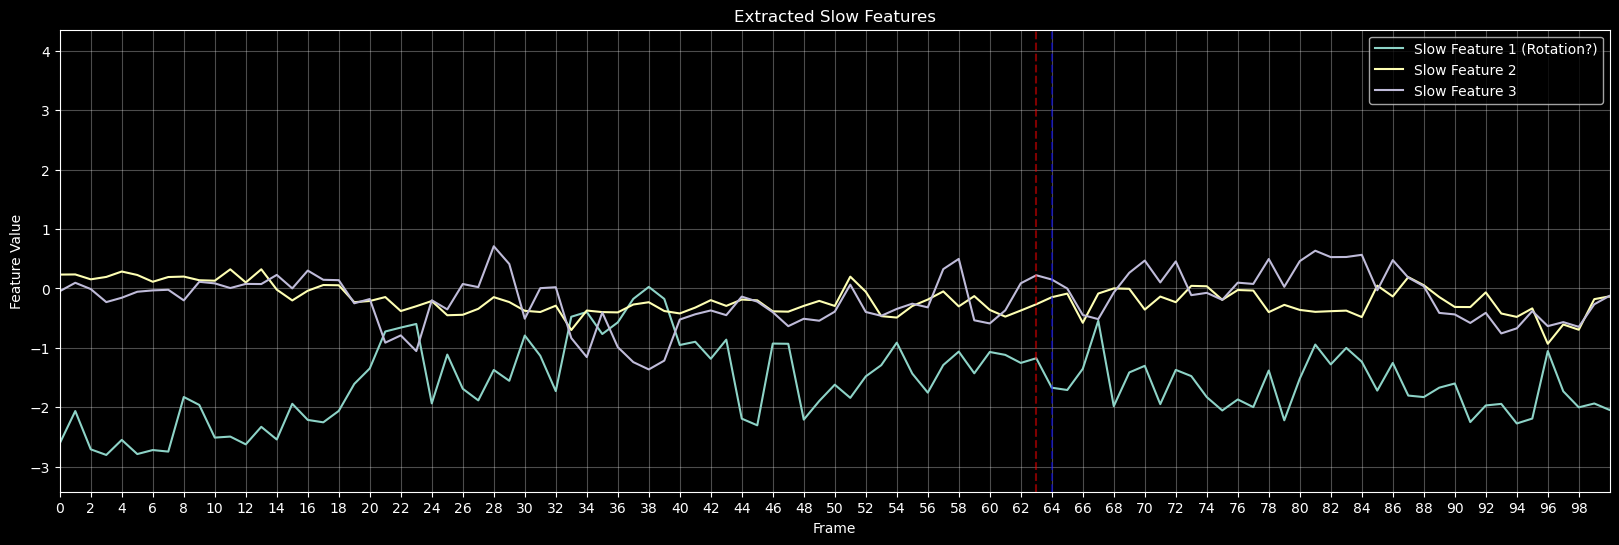

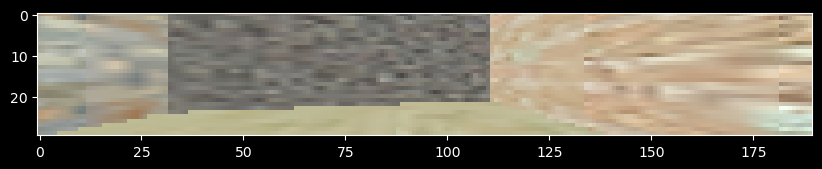

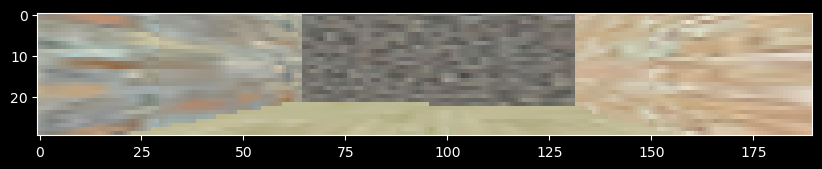

In [4]:
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot()

index1 = 63
index2 = index1+1

ax.plot(slow_features[:, 0], label="Slow Feature 1 (Rotation?)")
ax.plot(slow_features[:, 1], label="Slow Feature 2")
ax.plot(slow_features[:, 2], label="Slow Feature 3")
print('pos 1:', slow_features[index1])
print('pos 2:', slow_features[index2])
print(f'Max diff.: Slow feature #{np.argmax(np.abs(slow_features[index1] - slow_features[index2])) + 1}')
ax.legend()
ax.grid(alpha=.3)
hline = ax.axvline(index1, c='r', alpha=.5, linestyle='--')
hline = ax.axvline(index2, c='b', alpha=.5, linestyle='--')
plt.title("Extracted Slow Features")
plt.xlabel("Frame")
plt.ylabel("Feature Value")
length = 100
plt.xlim(0,length)
plt.xticks(np.arange(0, length, 2))

plt.figure(figsize=(10, 5))
plt.imshow(data[index1])
plt.figure(figsize=(10, 5))
plt.imshow(data[index2])
plt.show()

In [5]:
from minisom import MiniSom
from tqdm.notebook import tqdm
som = MiniSom(100, 100, 2, sigma=12, learning_rate=0.5)
som.random_weights_init(slow_features[:,1:])
som.train(slow_features[:,1:], 2000, random_order=True, verbose=True)
winners = [som.winner(x) for x in tqdm(slow_features[:,1:])]

 [ 2000 / 2000 ] 100% - 0:00:00 left 
 quantization error: 0.03477691843777565


  0%|          | 0/22000 [00:00<?, ?it/s]

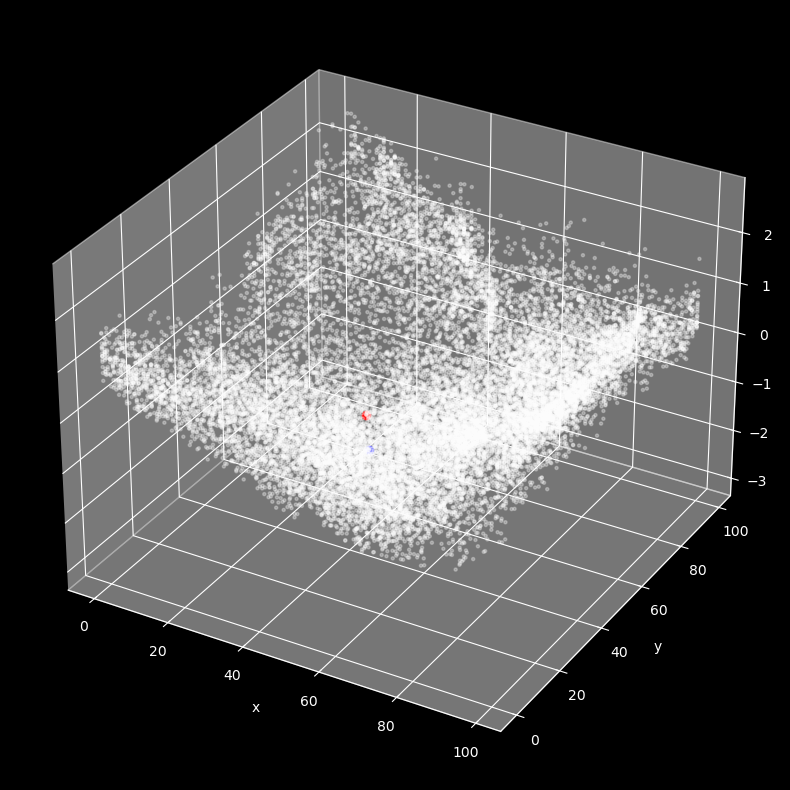

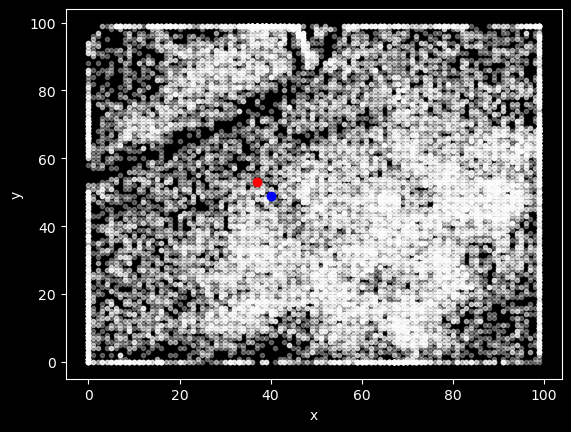

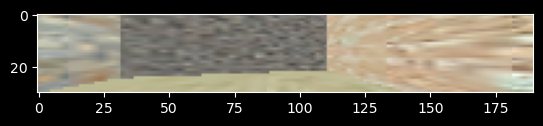

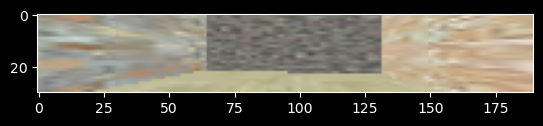

In [6]:
index = 63

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
winners = np.array(winners)
ax.scatter(winners[:,0], winners[:,1], slow_features[:,0], marker='.', c='white', alpha=.3)
ax.plot(winners[index,0], winners[index,1], slow_features[index,0], 'ro')
ax.plot(winners[index+1,0], winners[index+1,1], slow_features[index+1,0], 'bo')
plt.xlabel('x')
plt.ylabel('y')
plt.figure()
plt.scatter(winners[:,0], winners[:,1], marker='.', c='white', alpha=.3)
plt.plot(winners[index,0], winners[index,1], 'ro')
plt.plot(winners[index+1,0], winners[index+1,1], 'bo')
plt.xlabel('x')
plt.ylabel('y')
plt.figure()
plt.imshow(data[index])
plt.figure()
plt.imshow(data[index+1])
plt.show()